In [1]:
# === BRIGHT · Cell 1B: Rebuild manifest allowing missing pre-event ===
from pathlib import Path
import re, sys
import pandas as pd

# Repo-friendly path handling:
# - default expects datasets under the repo root: ./BRIGHT
# - you can override with environment variables:
#     BRIGHT_ROOT=/path/to/BRIGHT
sys.path.append(str(Path.cwd().resolve().parent if Path.cwd().name.lower()=="notebooks" else Path.cwd().resolve()))
from src.config import BRIGHT_ROOT as DATASET_ROOT

pre_dir   = DATASET_ROOT / "pre-event"
post_dir  = DATASET_ROOT / "post-event"
target_dir= DATASET_ROOT / "target"

print("Dataset root:", DATASET_ROOT)
print(" pre-event:", pre_dir, "| exists:", pre_dir.exists())
print("post-event:", post_dir, "| exists:", post_dir.exists())
print("   target:", target_dir, "| exists:", target_dir.exists())

pre_files   = sorted(pre_dir.glob("*.tif")) if pre_dir.exists() else []
post_files  = sorted(post_dir.glob("*.tif")) if post_dir.exists() else []
target_files= sorted(target_dir.glob("*.tif")) if target_dir.exists() else []

print("\nCounts")
print(f"  pre-event  .tif: {len(pre_files)}")
print(f"  post-event .tif: {len(post_files)}")
print(f"  target     .tif: {len(target_files)}")

def extract_scene_id(p: Path):
    s = p.stem
    for suf in ["_pre_disaster", "_post_disaster", "_building_damage"]:
        if s.endswith(suf):
            return s[: -len(suf)]
    return s  # fallback

def index_by_scene(files, required_suffix=None):
    out = {}
    for p in files:
        if required_suffix and not p.stem.endswith(required_suffix):
            continue
        sid = extract_scene_id(p)
        out[sid] = p
    return out

idx_pre   = index_by_scene(pre_files,   "_pre_disaster")
idx_post  = index_by_scene(post_files,  "_post_disaster")
idx_label = index_by_scene(target_files,"_building_damage")

# We’ll at least require (post + label) pairs
scene_ids_post_label = sorted(set(idx_post.keys()) & set(idx_label.keys()))
print("\nMatched (post + label) pairs:", len(scene_ids_post_label))

rows = []
for sid in scene_ids_post_label:
    rows.append({
        "scene_id": sid,
        "pre_path":   str(idx_pre[sid]) if sid in idx_pre else None,
        "post_path":  str(idx_post[sid]),
        "label_path": str(idx_label[sid]),
        "has_pre":    sid in idx_pre,
        "has_post":   True,
        "has_label":  True,
    })

manifest = pd.DataFrame(rows)
ARTIFACTS = Path("./artifacts_stage2"); ARTIFACTS.mkdir(exist_ok=True, parents=True)
csv_path = ARTIFACTS / "bright_manifest.csv"
manifest.to_csv(csv_path, index=False)

print("\nSaved manifest:", csv_path)
print("Rows:", len(manifest), "| with pre:", int(manifest['has_pre'].sum()))
display(manifest.head(8))

# quick per-event breakdown (prefix before first underscore)
def infer_event(sid: str): return sid.split("_")[0]
manifest["event"] = manifest["scene_id"].map(infer_event)
evt = manifest["event"].value_counts().to_frame("num_scenes")
print("\nScenes per event (top 15):")
display(evt.head(15))


Dataset root: C:\JP_Notebooks\CSCE 5380\Project\BRIGHT
 pre-event: C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\pre-event | exists: True
post-event: C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\post-event | exists: True
   target: C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\target | exists: True

Counts
  pre-event  .tif: 0
  post-event .tif: 4246
  target     .tif: 4246

Matched (post + label) pairs: 4246

Saved manifest: artifacts_stage2\bright_manifest.csv
Rows: 4246 | with pre: 0

Sample rows:


,scene_id,pre_path,post_path,label_path,has_pre,has_post,has_label
0,bata-explosion_00000000,None,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\post-...,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\targe...,False,True,True
1,bata-explosion_00000001,None,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\post-...,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\targe...,False,True,True
2,bata-explosion_00000002,None,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\post-...,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\targe...,False,True,True
3,bata-explosion_00000003,None,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\post-...,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\targe...,False,True,True
4,bata-explosion_00000004,None,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\post-...,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\targe...,False,True,True
5,bata-explosion_00000005,None,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\post-...,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\targe...,False,True,True
6,bata-explosion_00000006,None,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\post-...,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\targe...,False,True,True
7,bata-explosion_00000007,None,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\post-...,C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\targe...,False,True,True



Scenes per event (top 15):


,num_scenes
event,
turkey-earthquake,1114
la,933
morocco-earthquake,567
ukraine-conflict,513
mexico-hurricane,212
beirut-explosion,133
myanmar-hurricane,126
libya-flood,124
congo-volcano,123


Scene: bata-explosion_00000000
Post path: C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\post-event\bata-explosion_00000000_post_disaster.tif
Label path: C:\JP_Notebooks\CSCE 5380\Project\BRIGHT\target\bata-explosion_00000000_building_damage.tif
Post array shape: (1024, 1024) dtype: uint8
Label array shape: (1024, 1024) dtype: uint8

Unique label IDs & counts:
    0: 1008939 pixels (96.22%)
    1: 39637 pixels (3.78%)


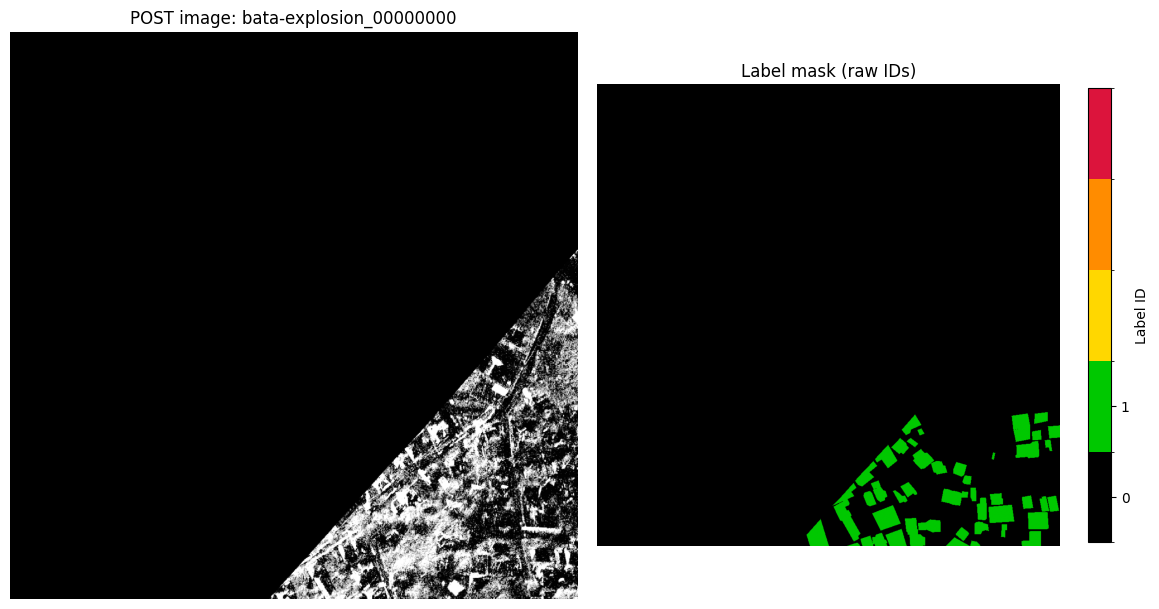


NOTE:
- The palette assumes IDs 1..4 correspond roughly to {No, Minor, Major, Destroyed}.
- Your actual IDs may differ; we’ll map exactly after we inspect a few scenes.
- If you see IDs > 4 (e.g., 5, 255), those are likely background/ignore.


In [2]:
# === BRIGHT · Cell 2: Visual check (post image + label mask) & label stats ===
# What this does:
# - Loads artifacts_stage2/bright_manifest.csv
# - Picks one scene
# - Reads post-event .tif and label .tif using tifffile
# - Displays post image (percentile-stretched RGB) and colorized label mask
# - Prints unique label IDs + counts so we know the class encoding

import sys
import numpy as np
import pandas as pd
from pathlib import Path

# try to import tifffile;
try:
    import tifffile as tiff
except ImportError:
    print("tifffile is not installed. Run this once in a cell:\n  %pip install tifffile")
    raise

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

ARTIFACTS = Path("./artifacts_stage2")
manifest_path = ARTIFACTS / "bright_manifest.csv"
assert manifest_path.exists(), f"Missing manifest: {manifest_path}"

m = pd.read_csv(manifest_path)
assert len(m), "Manifest is empty."

# ---- Choose a scene to inspect ----
# Option A: set a specific SCENE_ID (e.g., "turkey-earthquake_00001234")
SCENE_ID = None  # <-- put a string to force a specific scene, or leave as None

if SCENE_ID is not None and SCENE_ID in set(m["scene_id"]):
    row = m.loc[m["scene_id"] == SCENE_ID].iloc[0]
else:
    # Otherwise, pick the first row (or sample by event if you prefer)
    row = m.iloc[0]

scene_id = row["scene_id"]
post_path = Path(row["post_path"])
label_path = Path(row["label_path"])

print("Scene:", scene_id)
print("Post path:", post_path)
print("Label path:", label_path)
for p in [post_path, label_path]:
    if not Path(p).exists():
        raise FileNotFoundError(f"File not found: {p}")

# ---- Helper: safe read and prepare RGB for visualization ----
def read_tif(path: Path):
    arr = tiff.imread(str(path))
    return arr

def to_rgb_display(arr):
    """Return HxWx3 uint8 for display with percentile stretch."""
    # Expect shapes like (H,W,3) or (C,H,W)
    if arr.ndim == 3:
        # Identify channel axis
        if arr.shape[0] in (1,3,4) and arr.shape[2] not in (3,4):
            # assume channels-first (C,H,W) -> (H,W,C)
            arr = np.transpose(arr, (1,2,0))
        # If more than 3 bands, take first 3
        if arr.shape[2] > 3:
            arr = arr[:, :, :3]
    elif arr.ndim == 2:
        # single band; replicate to RGB
        arr = np.stack([arr, arr, arr], axis=-1)
    else:
        raise ValueError(f"Unexpected image shape: {arr.shape}")

    # Percentile stretch per-channel for visualization
    out = np.zeros_like(arr, dtype=np.float32)
    for c in range(arr.shape[2]):
        band = arr[..., c].astype(np.float32)
        p2, p98 = np.percentile(band[np.isfinite(band)], [2, 98])
        if p98 <= p2:
            p2, p98 = band.min(), band.max()
        band = np.clip((band - p2) / (p98 - p2 + 1e-6), 0, 1)
        out[..., c] = band
    return (out * 255).astype(np.uint8)

# ---- Read arrays ----
post_arr = read_tif(post_path)
label_arr = read_tif(label_path)

print("Post array shape:", post_arr.shape, "dtype:", post_arr.dtype)
print("Label array shape:", label_arr.shape, "dtype:", label_arr.dtype)

# ---- Compute label stats ----
# Ensure integer labels
label_int = label_arr.astype(np.int64, copy=False)
uniq, counts = np.unique(label_int, return_counts=True)
label_stats = {int(u): int(c) for u,c in zip(uniq, counts)}
total = int(label_int.size)

print("\nUnique label IDs & counts:")
for u,c in label_stats.items():
    print(f"  {u:>3}: {c} pixels ({c/total:.2%})")

# ---- Color map for label display (we'll map whatever unique IDs we see)
# We'll define up to 5 colors: background/unknown + {No, Minor, Major, Destroyed}
# If your labels already 0-3, these colors will align directly.
palette = np.array([
    [0,   0,   0  ],  # 0: background/ignore (black)
    [0,  200,   0],   # 1: No Damage (green)
    [255, 215,  0],   # 2: Minor Damage (gold)
    [255, 140,  0],   # 3: Major Damage (dark orange)
    [220,  20, 60],   # 4: Destroyed (crimson)
], dtype=np.uint8)

# Build cmap/norm that can handle arbitrary integer labels (0..max)
max_label = int(uniq.max())
cm = ListedColormap(palette / 255.0, name="damage_cmap", N=palette.shape[0])
bounds = np.arange(-0.5, palette.shape[0] + 0.5, 1.0)
norm = BoundaryNorm(bounds, cm.N)

# ---- Prepare image for display ----
post_rgb = to_rgb_display(post_arr)

# ---- Plot ----
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(post_rgb)
axs[0].set_title(f"POST image: {scene_id}")
axs[0].axis("off")

im = axs[1].imshow(label_int, cmap=cm, norm=norm)
axs[1].set_title("Label mask (raw IDs)")
axs[1].axis("off")
# add a colorbar with integer ticks up to present labels (capped by our palette)
ticks = sorted([int(u) for u in uniq if 0 <= int(u) < palette.shape[0]])
cbar = fig.colorbar(im, ax=axs[1], shrink=0.8, ticks=ticks)
cbar.ax.set_ylabel("Label ID")
plt.tight_layout()
plt.show()

print("\nNOTE:")
print("- The palette assumes IDs 1..4 correspond roughly to {No, Minor, Major, Destroyed}.")
print("- Your actual IDs may differ; we’ll map exactly after we inspect a few scenes.")
print("- If you see IDs > 4 (e.g., 5, 255), those are likely background/ignore.")

In [3]:
# === BRIGHT · Cell 3: Tile generator (256×256 crops) ===
# Creates non-empty tiles from post-event images and binary masks.
# This will be used to train a U-Net later.

import numpy as np, pandas as pd
import tifffile as tiff
from pathlib import Path
from tqdm.auto import tqdm
import shutil

# Config
TILE_SIZE = 256
STRIDE = 256  # no overlap; set <256 for overlap
MIN_POSITIVE_PIXELS = 500  # skip tiles with < this many damaged pixels
ARTIFACTS = Path("./artifacts_stage2")
manifest = pd.read_csv(ARTIFACTS / "bright_manifest.csv")

# Output dirs
tile_root = ARTIFACTS / "tiles"
for sub in ["post", "label"]:
    out = tile_root / sub
    if out.exists():
        shutil.rmtree(out)
    out.mkdir(parents=True, exist_ok=True)

def sliding_window(arr, step, size):
    """Generate (y,x) windows for HxW array"""
    H, W = arr.shape[:2]
    for y in range(0, H, step):
        for x in range(0, W, step):
            if y + size <= H and x + size <= W:
                yield y, x

# List of generated tile metadata
rows = []
print("Generating tiles...")
for _, row in tqdm(manifest.iterrows(), total=len(manifest)):
    sid = row["scene_id"]
    post_p = Path(row["post_path"])
    lab_p  = Path(row["label_path"])
    if not post_p.exists() or not lab_p.exists():
        continue

    post = tiff.imread(str(post_p))
    lab  = tiff.imread(str(lab_p))

    # ensure 2D or 3-channel
    if post.ndim == 2:
        post = np.stack([post]*3, axis=-1)
    elif post.ndim == 3 and post.shape[0] in (1,3,4):
        post = np.transpose(post, (1,2,0))
    if lab.ndim > 2:
        lab = lab.squeeze()

    H, W = lab.shape
    for y,x in sliding_window(lab, STRIDE, TILE_SIZE):
        sub_lab = lab[y:y+TILE_SIZE, x:x+TILE_SIZE]
        if np.sum(sub_lab > 0) < MIN_POSITIVE_PIXELS:
            # skip empty tiles (mostly background)
            continue
        sub_img = post[y:y+TILE_SIZE, x:x+TILE_SIZE, :]
        out_img = tile_root/"post"/f"{sid}_{y}_{x}.npy"
        out_lab = tile_root/"label"/f"{sid}_{y}_{x}.npy"
        np.save(out_img, sub_img.astype(np.uint8))
        np.save(out_lab, sub_lab.astype(np.uint8))
        rows.append({"scene_id": sid, "tile_y": y, "tile_x": x,
                     "post_tile": str(out_img), "label_tile": str(out_lab)})

tiles_df = pd.DataFrame(rows)
csv_tiles = ARTIFACTS/"tiles_manifest.csv"
tiles_df.to_csv(csv_tiles, index=False)

print(f"\nSaved {len(tiles_df)} tiles to {csv_tiles}")
if len(tiles_df):
    print("Sample:")
    display(tiles_df.head(10))

# Basic stats
pos_counts = []
for f in tqdm(tiles_df["label_tile"].head(500)):  # sample for speed
    arr = np.load(f)
    pos_counts.append(np.mean(arr > 0))
pos_ratio = np.mean(pos_counts)
print(f"Avg positive ratio (fraction of damaged pixels): {pos_ratio:.3f}")

Generating tiles...


  0%|          | 0/4246 [00:00<?, ?it/s]


Saved 36832 tiles to artifacts_stage2\tiles_manifest.csv
Sample:


,scene_id,tile_y,tile_x,post_tile,label_tile
0,bata-explosion_00000000,512,512,artifacts_stage2\tiles\post\bata-explosion_000...,artifacts_stage2\tiles\label\bata-explosion_00...
1,bata-explosion_00000000,512,768,artifacts_stage2\tiles\post\bata-explosion_000...,artifacts_stage2\tiles\label\bata-explosion_00...
2,bata-explosion_00000000,768,256,artifacts_stage2\tiles\post\bata-explosion_000...,artifacts_stage2\tiles\label\bata-explosion_00...
3,bata-explosion_00000000,768,512,artifacts_stage2\tiles\post\bata-explosion_000...,artifacts_stage2\tiles\label\bata-explosion_00...
4,bata-explosion_00000000,768,768,artifacts_stage2\tiles\post\bata-explosion_000...,artifacts_stage2\tiles\label\bata-explosion_00...
5,bata-explosion_00000001,0,0,artifacts_stage2\tiles\post\bata-explosion_000...,artifacts_stage2\tiles\label\bata-explosion_00...
6,bata-explosion_00000001,0,256,artifacts_stage2\tiles\post\bata-explosion_000...,artifacts_stage2\tiles\label\bata-explosion_00...
7,bata-explosion_00000001,0,512,artifacts_stage2\tiles\post\bata-explosion_000...,artifacts_stage2\tiles\label\bata-explosion_00...
8,bata-explosion_00000001,0,768,artifacts_stage2\tiles\post\bata-explosion_000...,artifacts_stage2\tiles\label\bata-explosion_00...
9,bata-explosion_00000001,256,0,artifacts_stage2\tiles\post\bata-explosion_000...,artifacts_stage2\tiles\label\bata-explosion_00...


  0%|          | 0/500 [00:00<?, ?it/s]

Avg positive ratio (fraction of damaged pixels): 0.119


Loaders ready. train batches: 3240 | dev: 687 | test: 678

Showing a random training tile for sanity...


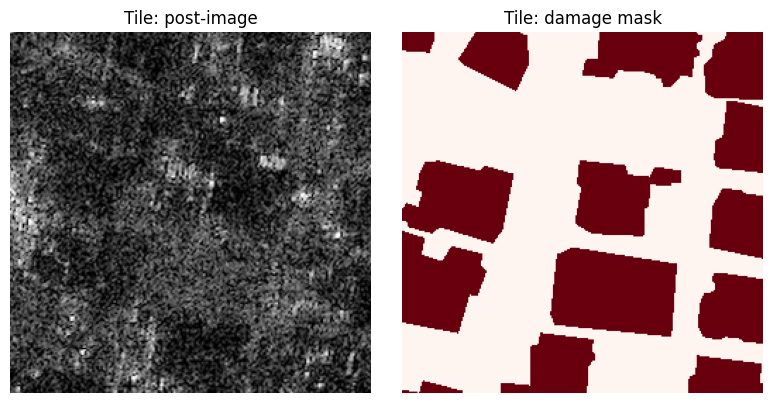

In [4]:
# === BRIGHT · Cell 4: Rebuild loaders & show a sample (standalone) ===
from pathlib import Path
import numpy as np, pandas as pd, random, matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

ARTIFACTS = Path("./artifacts_stage2")
splits_dir = ARTIFACTS / "splits"
assert (splits_dir/"train_tiles.csv").exists(), "Missing splits. Re-run Cell 4 first."

# Reload splits (scene-level)
train_df = pd.read_csv(splits_dir/"train_tiles.csv")
dev_df   = pd.read_csv(splits_dir/"dev_tiles.csv")
test_df  = pd.read_csv(splits_dir/"test_tiles.csv")

def _flip_lr(x):  # left-right
    return np.flip(x, axis=-1).copy()
def _flip_ud(x):  # up-down
    return np.flip(x, axis=-2).copy()

class BrightTileDS_Safe(Dataset):
    def __init__(self, frame, augment=False):
        self.df = frame.reset_index(drop=True)
        self.augment = augment
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = np.load(r["post_tile"])   # HxWx3 uint8
        msk = np.load(r["label_tile"])  # HxW uint8 (0/1)
        # to float [0,1], CHW
        img = (img.astype(np.float32)/255.0).transpose(2,0,1)  # 3xHxW
        msk = (msk>0).astype(np.float32)[None,...]              # 1xHxW
        # simple aug
        if self.augment:
            if random.random()<0.5:
                img = _flip_lr(img); msk = _flip_lr(msk)
            if random.random()<0.5:
                img = _flip_ud(img); msk = _flip_ud(msk)
        # ensure contiguous for torch
        img = np.ascontiguousarray(img); msk = np.ascontiguousarray(msk)
        return torch.from_numpy(img), torch.from_numpy(msk)

# Build loaders (Windows: num_workers=0)
BATCH = 8
train_ds = BrightTileDS_Safe(train_df, augment=True)
dev_ds   = BrightTileDS_Safe(dev_df,   augment=False)
test_ds  = BrightTileDS_Safe(test_df,  augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=False)
dev_loader   = DataLoader(dev_ds,   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=False)

print("Loaders ready.",
      f"train batches: {len(train_loader)} | dev: {len(dev_loader)} | test: {len(test_loader)}")

# Visual sanity check
def show_sample(ds):
    i = random.randrange(len(ds))
    x,y = ds[i]  # x: 3xHxW, y: 1xHxW
    x_disp = (x.numpy().transpose(1,2,0)*255).clip(0,255).astype(np.uint8)
    y_disp = y.numpy()[0]
    fig,axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(x_disp); axs[0].set_title("Tile: post-image"); axs[0].axis("off")
    axs[1].imshow(y_disp, cmap="Reds"); axs[1].set_title("Tile: damage mask"); axs[1].axis("off")
    plt.tight_layout(); plt.show()

print("\nShowing a random training tile for sanity...")
show_sample(train_ds)

In [5]:
# Ensure tqdm uses the notebook widget if available; else fall back to text bars.

import sys

# 1) Make sure ipywidgets is installed (no restart needed on recent Jupyter)
try:
    import ipywidgets as widgets
except Exception:
    print("Installing ipywidgets…")
    %pip -q install ipywidgets==8.1.3
    import ipywidgets as widgets

# 2) Try to use notebook tqdm; if it fails, fall back to auto
try:
    from tqdm.notebook import tqdm as _tqdm_nb
    _ = _tqdm_nb(range(1), desc="tqdm notebook probe")
    TQDM = _tqdm_nb
    print("tqdm: using notebook widget ✅")
except Exception as e:
    from tqdm.auto import tqdm as _tqdm_auto
    TQDM = _tqdm_auto
    print("tqdm: notebook widget not available — using text bar ✅")

tqdm notebook probe:   0%|          | 0/1 [00:00<?, ?it/s]

tqdm: using notebook widget ✅


In [6]:
# === BRIGHT · Cell 5 ===
# U-Net training with notebook tqdm + updated torch.amp APIs

import os, random, time
from pathlib import Path
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# use TQDM chosen in Cell A
try:
    TQDM
except NameError:
    from tqdm.auto import tqdm as TQDM  # fallback if Cell A wasn't run

ARTIFACTS = Path("./artifacts_stage2")
splits_dir = ARTIFACTS / "splits"
assert (splits_dir/"train_tiles.csv").exists(), "Missing splits. Re-run Cell 4."

# ---------- loaders ----------
def _flip_lr(x):  return np.flip(x, axis=-1).copy()
def _flip_ud(x):  return np.flip(x, axis=-2).copy()

class BrightTileDS_Safe(Dataset):
    def __init__(self, frame, augment=False):
        self.df = frame.reset_index(drop=True)
        self.augment = augment
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = np.load(r["post_tile"])      # HxWx3 uint8
        msk = np.load(r["label_tile"])     # HxW uint8 (0/1)
        img = (img.astype(np.float32)/255.0).transpose(2,0,1)  # 3xHxW
        msk = (msk>0).astype(np.float32)[None,...]              # 1xHxW
        if self.augment:
            if random.random()<0.5: img=_flip_lr(img); msk=_flip_lr(msk)
            if random.random()<0.5: img=_flip_ud(img); msk=_flip_ud(msk)
        img = np.ascontiguousarray(img); msk = np.ascontiguousarray(msk)
        return torch.from_numpy(img), torch.from_numpy(msk)

train_df = pd.read_csv(splits_dir/"train_tiles.csv")
dev_df   = pd.read_csv(splits_dir/"dev_tiles.csv")
test_df  = pd.read_csv(splits_dir/"test_tiles.csv")

BATCH = 8
train_loader = DataLoader(BrightTileDS_Safe(train_df, augment=True), batch_size=BATCH, shuffle=True,  num_workers=0)
dev_loader   = DataLoader(BrightTileDS_Safe(dev_df,   augment=False), batch_size=BATCH, shuffle=False, num_workers=0)
test_loader  = DataLoader(BrightTileDS_Safe(test_df,  augment=False), batch_size=BATCH, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device} | train batches: {len(train_loader)} | dev: {len(dev_loader)} | test: {len(test_loader)}")

# ---------- tiny U-Net ----------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32):
        super().__init__()
        self.down1=DoubleConv(in_ch,base);   self.pool1=nn.MaxPool2d(2)
        self.down2=DoubleConv(base,base*2);  self.pool2=nn.MaxPool2d(2)
        self.down3=DoubleConv(base*2,base*4);self.pool3=nn.MaxPool2d(2)
        self.down4=DoubleConv(base*4,base*8);self.pool4=nn.MaxPool2d(2)
        self.mid  =DoubleConv(base*8,base*16)
        self.up4=nn.ConvTranspose2d(base*16,base*8,2,2); self.dec4=DoubleConv(base*16,base*8)
        self.up3=nn.ConvTranspose2d(base*8,base*4,2,2);  self.dec3=DoubleConv(base*8,base*4)
        self.up2=nn.ConvTranspose2d(base*4,base*2,2,2);  self.dec2=DoubleConv(base*4,base*2)
        self.up1=nn.ConvTranspose2d(base*2,base,2,2);    self.dec1=DoubleConv(base*2,base)
        self.outc=nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        x1=self.down1(x); x2=self.down2(self.pool1(x1)); x3=self.down3(self.pool2(x2)); x4=self.down4(self.pool3(x3))
        xm=self.mid(self.pool4(x4))
        y4=self.dec4(torch.cat([self.up4(xm),x4],1))
        y3=self.dec3(torch.cat([self.up3(y4),x3],1))
        y2=self.dec2(torch.cat([self.up2(y3),x2],1))
        y1=self.dec1(torch.cat([self.up1(y2),x1],1))
        return self.outc(y1)

# ---------- loss & metrics ----------
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.6, smooth=1.0):
        super().__init__()
        self.bce=nn.BCEWithLogitsLoss(); self.w=bce_weight; self.s=smooth
    def forward(self, logits, target):
        bce=self.bce(logits,target)
        with torch.no_grad():
            pass
        probs=torch.sigmoid(logits)
        num=2*(probs*target).sum((2,3))+self.s
        den=(probs*probs).sum((2,3))+(target*target).sum((2,3))+self.s
        dice=1-(num/den).mean()
        return self.w*bce+(1-self.w)*dice

def iou_f1_from_logits(logits, target, thr=0.5, eps=1e-7):
    probs=torch.sigmoid(logits); pred=(probs>=thr).float()
    tp=(pred*target).sum((2,3)); fp=(pred*(1-target)).sum((2,3)); fn=((1-pred)*target).sum((2,3))
    iou=((tp+eps)/(tp+fp+fn+eps)).mean().item()
    prec=((tp+eps)/(tp+fp+eps)).mean().item()
    rec =((tp+eps)/(tp+fn+eps)).mean().item()
    f1 =(2*prec*rec/(prec+rec+eps))
    return iou, f1

model=UNetSmall().to(device)
opt=torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# updated AMP APIs
scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available())
use_amp = torch.cuda.is_available()

EPOCHS=8; patience=3; best=-1.0; stall=0
save_dir=ARTIFACTS/"models"/"unet_bce_dice"; save_dir.mkdir(parents=True, exist_ok=True)
best_path=save_dir/"best.pt"; logs=[]

print("=== Training start ===")
for ep in range(1, EPOCHS+1):
    # train
    model.train(); trL=trI=trF=0.0; n=0
    pbar=TQDM(train_loader, desc=f"Epoch {ep}/{EPOCHS} [train]", unit="batch", mininterval=0.1, leave=True)
    for x,y in pbar:
        x=x.to(device); y=y.to(device)
        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=use_amp):
            logits=model(x); loss=BCEDiceLoss(0.6)(logits,y)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        iou,f1=iou_f1_from_logits(logits.detach(), y)
        n+=1; trL+=float(loss); trI+=iou; trF+=f1
        pbar.set_postfix(loss=trL/n, iou=trI/n, f1=trF/n)
    trL/=n; trI/=n; trF/=n

    # valid
    model.eval(); vaL=vaI=vaF=0.0; n=0
    with torch.inference_mode(), torch.amp.autocast('cuda', enabled=use_amp):
        vpbar=TQDM(dev_loader, desc=f"Epoch {ep}/{EPOCHS} [valid]", unit="batch", mininterval=0.1, leave=True)
        for x,y in vpbar:
            x=x.to(device); y=y.to(device)
            logits=model(x); loss=BCEDiceLoss(0.6)(logits,y)
            iou,f1=iou_f1_from_logits(logits,y)
            n+=1; vaL+=float(loss); vaI+=iou; vaF+=f1
            vpbar.set_postfix(loss=vaL/n, iou=vaI/n, f1=vaF/n)
    vaL/=n; vaI/=n; vaF/=n

    print(f">> Epoch {ep} | train {trL:.4f}/{trI:.3f}/{trF:.3f} | valid {vaL:.4f}/{vaI:.3f}/{vaF:.3f}")
    logs.append(dict(epoch=ep,tr_loss=trL,tr_iou=trI,tr_f1=trF,va_loss=vaL,va_iou=vaI,va_f1=vaF))

    if vaI>best+1e-4:
        best=vaI; stall=0; torch.save(model.state_dict(), best_path)
        print(f"  * new best val IoU {best:.3f} saved -> {best_path}")
    else:
        stall+=1
        if stall>=patience:
            print("Early stopping."); break

pd.DataFrame(logs).to_csv(save_dir/"train_log.csv", index=False)

# test
if best_path.exists(): model.load_state_dict(torch.load(best_path, map_location=device))
model.eval(); TI=TF=0.0; n=0
with torch.inference_mode(), torch.amp.autocast('cuda', enabled=use_amp):
    for x,y in TQDM(test_loader, desc="Testing", unit="batch", mininterval=0.1, leave=True):
        x=x.to(device); y=y.to(device)
        logits=model(x); i,f=iou_f1_from_logits(logits,y); TI+=i; TF+=f; n+=1
TI/=n; TF/=n
print(f"\n=== TEST ===\nIoU@0.5: {TI:.3f} | F1@0.5: {TF:.3f}")

Device: cuda | train batches: 3240 | dev: 687 | test: 678
=== Training start ===


Epoch 1/8 [train]:   0%|          | 0/3240 [00:00<?, ?batch/s]

Epoch 1/8 [valid]:   0%|          | 0/687 [00:00<?, ?batch/s]

>> Epoch 1 | train 0.5173/0.228/0.410 | valid 0.5016/0.247/0.392
  * new best val IoU 0.247 saved -> artifacts_stage2\models\unet_bce_dice\best.pt


Epoch 2/8 [train]:   0%|          | 0/3240 [00:00<?, ?batch/s]

Epoch 2/8 [valid]:   0%|          | 0/687 [00:00<?, ?batch/s]

>> Epoch 2 | train 0.4962/0.263/0.446 | valid 0.4777/0.247/0.393
  * new best val IoU 0.247 saved -> artifacts_stage2\models\unet_bce_dice\best.pt


Epoch 3/8 [train]:   0%|          | 0/3240 [00:00<?, ?batch/s]

Epoch 3/8 [valid]:   0%|          | 0/687 [00:00<?, ?batch/s]

>> Epoch 3 | train 0.4869/0.276/0.457 | valid 0.4791/0.234/0.375


Epoch 4/8 [train]:   0%|          | 0/3240 [00:00<?, ?batch/s]

Epoch 4/8 [valid]:   0%|          | 0/687 [00:00<?, ?batch/s]

>> Epoch 4 | train 0.4813/0.284/0.465 | valid 0.4699/0.312/0.469
  * new best val IoU 0.312 saved -> artifacts_stage2\models\unet_bce_dice\best.pt


Epoch 5/8 [train]:   0%|          | 0/3240 [00:00<?, ?batch/s]

Epoch 5/8 [valid]:   0%|          | 0/687 [00:00<?, ?batch/s]

>> Epoch 5 | train 0.4758/0.291/0.472 | valid 0.4619/0.283/0.435


Epoch 6/8 [train]:   0%|          | 0/3240 [00:00<?, ?batch/s]

Epoch 6/8 [valid]:   0%|          | 0/687 [00:00<?, ?batch/s]

>> Epoch 6 | train 0.4718/0.297/0.477 | valid 0.4625/0.334/0.495
  * new best val IoU 0.334 saved -> artifacts_stage2\models\unet_bce_dice\best.pt


Epoch 7/8 [train]:   0%|          | 0/3240 [00:00<?, ?batch/s]

Epoch 7/8 [valid]:   0%|          | 0/687 [00:00<?, ?batch/s]

>> Epoch 7 | train 0.4680/0.302/0.482 | valid 0.4552/0.312/0.469


Epoch 8/8 [train]:   0%|          | 0/3240 [00:00<?, ?batch/s]

Epoch 8/8 [valid]:   0%|          | 0/687 [00:00<?, ?batch/s]

>> Epoch 8 | train 0.4656/0.306/0.486 | valid 0.4721/0.337/0.497
  * new best val IoU 0.337 saved -> artifacts_stage2\models\unet_bce_dice\best.pt


C:\Users\shrey\AppData\Local\Temp\ipykernel_86244\4110422569.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if best_path.exists(): model.load_state_dict(torch.load(be

Testing:   0%|          | 0/678 [00:00<?, ?batch/s]


=== TEST ===
IoU@0.5: 0.329 | F1@0.5: 0.488


In [16]:
# === Cell 6: Fast inference for BRIGHT U-Net on 10 scenes ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from tqdm.auto import tqdm

ARTIFACTS = Path("./artifacts_stage2")
MODEL_PATH = ARTIFACTS / "models" / "unet_bce_dice" / "best.pt"
SPLITS_DIR = ARTIFACTS / "splits"
assert MODEL_PATH.exists(), f"Checkpoint not found: {MODEL_PATH}"
assert (SPLITS_DIR/"test_tiles.csv").exists(), "Run the split cell first."

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- same model as training ----
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32):
        super().__init__()
        self.down1=DoubleConv(in_ch,base);   self.pool1=nn.MaxPool2d(2)
        self.down2=DoubleConv(base,base*2);  self.pool2=nn.MaxPool2d(2)
        self.down3=DoubleConv(base*2,base*4);self.pool3=nn.MaxPool2d(2)
        self.down4=DoubleConv(base*4,base*8);self.pool4=nn.MaxPool2d(2)
        self.mid  =DoubleConv(base*8,base*16)
        self.up4=nn.ConvTranspose2d(base*16,base*8,2,2); self.dec4=DoubleConv(base*16,base*8)
        self.up3=nn.ConvTranspose2d(base*8,base*4,2,2);  self.dec3=DoubleConv(base*8,base*4)
        self.up2=nn.ConvTranspose2d(base*4,base*2,2,2);  self.dec2=DoubleConv(base*4,base*2)
        self.up1=nn.ConvTranspose2d(base*2,base,2,2);    self.dec1=DoubleConv(base*2,base)
        self.outc=nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        x1=self.down1(x); x2=self.down2(self.pool1(x1)); x3=self.down3(self.pool2(x2)); x4=self.down4(self.pool3(x3))
        xm=self.mid(self.pool4(x4))
        y4=self.dec4(torch.cat([self.up4(xm),x4],1))
        y3=self.dec3(torch.cat([self.up3(y4),x3],1))
        y2=self.dec2(torch.cat([self.up2(y3),x2],1))
        y1=self.dec1(torch.cat([self.up1(y2),x1],1))
        return self.outc(y1)

# ---- dataset from saved .npy tiles ----
class TileEvalDS(Dataset):
    def __init__(self, df): self.df=df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r=self.df.iloc[i]
        img=np.load(r["post_tile"])          # HxWx3 uint8
        msk=np.load(r["label_tile"])         # HxW   uint8 {0,1}
        x=(img.astype(np.float32)/255.).transpose(2,0,1)  # 3xHxW
        y=(msk>0).astype(np.float32)[None,...]            # 1xHxW
        return torch.from_numpy(x), torch.from_numpy(y), r["scene_id"]

# ---- pick 10 scenes from test split ----
test_df = pd.read_csv(SPLITS_DIR/"test_tiles.csv")
scenes = sorted(test_df["scene_id"].unique())[:10]
sub_df = test_df[test_df["scene_id"].isin(scenes)].reset_index(drop=True)
print(f"Scenes: {len(scenes)} | Tiles: {len(sub_df)}")

loader = DataLoader(TileEvalDS(sub_df), batch_size=16, shuffle=False, num_workers=0)

# ---- load model ----
model = UNetSmall().to(device)
state = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
use_amp = torch.cuda.is_available()

def iou_f1(pred, target, thr=0.5, eps=1e-7):
    pb = (pred>=thr).float()
    tp=(pb*target).sum((2,3)); fp=(pb*(1-target)).sum((2,3)); fn=((1-pb)*target).sum((2,3))
    iou=((tp+eps)/(tp+fp+fn+eps))
    prec=((tp+eps)/(tp+fp+eps)); rec=((tp+eps)/(tp+fn+eps))
    f1=(2*prec*rec/(prec+rec+eps))
    return iou.mean().item(), f1.mean().item()

# ---- run inference ----
per_scene = {sid: {"tp":0.0, "fp":0.0, "fn":0.0, "n":0} for sid in scenes}
overlay_dir = ARTIFACTS/"inference_fast_overlays"; overlay_dir.mkdir(parents=True, exist_ok=True)

with torch.inference_mode(), torch.amp.autocast('cuda', enabled=use_amp):
    pbar = tqdm(loader, desc="Inf (U-Net)")
    for xb, yb, sids in pbar:
        xb=xb.to(device); yb=yb.to(device)
        logits = model(xb)
        probs  = torch.sigmoid(logits)
        # aggregate per scene
        pb = (probs>=0.5).float()
        tp=(pb*yb).sum((2,3)).cpu().numpy()
        fp=(pb*(1-yb)).sum((2,3)).cpu().numpy()
        fn=(((1-pb)*yb)).sum((2,3)).cpu().numpy()
        for i, sid in enumerate(sids):
            d=per_scene[sid]
            d["tp"] += float(tp[i]); d["fp"] += float(fp[i]); d["fn"] += float(fn[i]); d["n"] += 1

        # visualize a couple of random tiles
        if np.random.rand() < 0.02:
            x = (xb[0].cpu().numpy().transpose(1,2,0)*255).astype(np.uint8)
            m = yb[0,0].cpu().numpy()
            p = probs[0,0].cpu().numpy()
            plt.figure(figsize=(9,3))
            plt.subplot(1,3,1); plt.imshow(x); plt.title("Tile"); plt.axis("off")
            plt.subplot(1,3,2); plt.imshow(m, cmap="gray"); plt.title("GT mask"); plt.axis("off")
            plt.subplot(1,3,3); plt.imshow(x); plt.imshow(p>=0.5, cmap="Reds", alpha=0.4); plt.title("Pred overlay"); plt.axis("off")
            plt.tight_layout(); plt.show()

# ---- compute scene metrics ----
rows=[]
for sid, d in per_scene.items():
    tp,fp,fn = d["tp"], d["fp"], d["fn"]
    iou = tp / (tp+fp+fn+1e-7)
    prec = tp / (tp+fp+1e-7)
    rec  = tp / (tp+fn+1e-7)
    f1   = (2*prec*rec)/(prec+rec+1e-7)
    rows.append({"scene_id": sid, "tiles": d["n"], "IoU": float(iou), "F1": float(f1)})
summary = pd.DataFrame(rows).sort_values("IoU", ascending=False).reset_index(drop=True)
summary_path = ARTIFACTS/"preds_fast_summary.csv"
summary.to_csv(summary_path, index=False)
print(f"\nSaved per-scene summary → {summary_path}")
display(summary.head(10))

print(f"Macro avg: IoU={summary['IoU'].mean():.3f} | F1={summary['F1'].mean():.3f}")

Device: cuda
Scenes: 10 | Tiles: 106


C:\Users\shrey\AppData\Local\Temp\ipykernel_86244\553004457.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_PATH, map_location=device)


Inf (U-Net):   0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\shrey\AppData\Local\Temp\ipykernel_86244\553004457.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d["tp"] += float(tp[i]); d["fp"] += float(fp[i]); d["fn"] += float(fn[i]); d["n"] += 1



Saved per-scene summary → artifacts_stage2\preds_fast_summary.csv


,scene_id,tiles,IoU,F1
0,bata-explosion_00000007,12,0.347365,0.515621
1,bata-explosion_00000017,15,0.342052,0.509745
2,bata-explosion_00000046,14,0.341296,0.508905
3,bata-explosion_00000032,11,0.333486,0.500172
4,bata-explosion_00000033,16,0.320350,0.485250
5,bata-explosion_00000012,2,0.318199,0.482778
6,bata-explosion_00000031,11,0.253845,0.404906
7,bata-explosion_00000014,11,0.243192,0.391238
8,bata-explosion_00000000,5,0.212181,0.350081
9,bata-explosion_00000052,9,0.126088,0.223940


Macro avg: IoU=0.284 | F1=0.437


In [18]:
# === Cell 7: Top-K scene overlays + montage ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math
from pathlib import Path
import torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from PIL import Image

ARTIFACTS = Path("./artifacts_stage2")
SPLITS = ARTIFACTS/"splits"
SUMMARY_CSV = ARTIFACTS/"preds_fast_summary.csv"   # from Cell 6
MODEL_PATH = ARTIFACTS/"models"/"unet_bce_dice"/"best.pt"
assert Path(SUMMARY_CSV).exists(), "Run Cell 6 first (it creates preds_fast_summary.csv)."

# ---- model (same as training) ----
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32):
        super().__init__()
        self.down1=DoubleConv(in_ch,base);   self.pool1=nn.MaxPool2d(2)
        self.down2=DoubleConv(base,base*2);  self.pool2=nn.MaxPool2d(2)
        self.down3=DoubleConv(base*2,base*4);self.pool3=nn.MaxPool2d(2)
        self.down4=DoubleConv(base*4,base*8);self.pool4=nn.MaxPool2d(2)
        self.mid  =DoubleConv(base*8,base*16)
        self.up4=nn.ConvTranspose2d(base*16,base*8,2,2); self.dec4=DoubleConv(base*16,base*8)
        self.up3=nn.ConvTranspose2d(base*8,base*4,2,2);  self.dec3=DoubleConv(base*8,base*4)
        self.up2=nn.ConvTranspose2d(base*4,base*2,2,2);  self.dec2=DoubleConv(base*4,base*2)
        self.up1=nn.ConvTranspose2d(base*2,base,2,2);    self.dec1=DoubleConv(base*2,base)
        self.outc=nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        x1=self.down1(x); x2=self.down2(self.pool1(x1)); x3=self.down3(self.pool2(x2)); x4=self.down4(self.pool3(x3))
        xm=self.mid(self.pool4(x4))
        y4=self.dec4(torch.cat([self.up4(xm),x4],1))
        y3=self.dec3(torch.cat([self.up3(y4),x3],1))
        y2=self.dec2(torch.cat([self.up2(y3),x2],1))
        y1=self.dec1(torch.cat([self.up1(y2),x1],1))
        return self.outc(y1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetSmall().to(device)
state = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
use_amp = torch.cuda.is_available()

# ---- load Top-K scenes from summary ----
summary = pd.read_csv(SUMMARY_CSV)
K = min(10, len(summary))
top = summary.head(K)["scene_id"].tolist()

# ---- fetch tiles for those scenes ----
test_df = pd.read_csv(SPLITS/"test_tiles.csv")
top_tiles = test_df[test_df["scene_id"].isin(top)].copy()

# helper to make overlay panels for a single scene
def render_scene_grid(scene_id, max_tiles=6, tile_size=256):
    df = top_tiles[top_tiles["scene_id"]==scene_id].head(max_tiles)
    if df.empty: return None
    cols = 3; rows = int(math.ceil(len(df)/cols))
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3.4, rows*3.2))
    axs = np.atleast_1d(axs).ravel()

    with torch.inference_mode(), torch.amp.autocast('cuda', enabled=use_amp):
        for ax, (_, r) in zip(axs, df.iterrows()):
            img = np.load(r["post_tile"])              # HxWx3 uint8
            msk = np.load(r["label_tile"]).astype(bool)
            x = (img.astype(np.float32)/255.).transpose(2,0,1)[None,...]
            xb = torch.from_numpy(x).to(device)
            prob = torch.sigmoid(model(xb))[0,0].cpu().numpy()

            ax.imshow(img)
            ax.imshow(prob>=0.5, cmap="Reds", alpha=0.35)
            ax.set_title(r["scene_id"].split("_")[0])
            ax.axis("off")

    for ax in axs[len(df):]:
        ax.axis("off")
    plt.tight_layout()
    out_dir = ARTIFACTS/"inference_fast_overlays"
    out_dir.mkdir(parents=True, exist_ok=True)
    png = out_dir/f"{scene_id}_grid.png"
    fig.savefig(png, dpi=140); plt.close(fig)
    return png

print("Rendering overlays...")
overlay_pngs = []
for sid in top:
    p = render_scene_grid(sid)
    if p is not None: overlay_pngs.append(str(p))

# ---- build a montage of top-K scene grids ----
if overlay_pngs:
    imgs = [Image.open(p) for p in overlay_pngs]
    cols = 2; rows = int(math.ceil(len(imgs)/cols))
    w,h = imgs[0].size
    from PIL import ImageDraw, ImageFont
    montage = Image.new("RGB", (cols*w, rows*h), (255,255,255))
    for i,im in enumerate(imgs):
        r, c = divmod(i, cols)
        montage.paste(im, (c*w, r*h))
    out = ARTIFACTS/"inference_fast_overlays"/"topK_montage.png"
    montage.save(out)
    print("Saved montage:", out)
else:
    print("No overlays generated.")

C:\Users\shrey\AppData\Local\Temp\ipykernel_86244\1700853839.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_PATH, map_location=device)


Rendering overlays...
Saved montage: artifacts_stage2\inference_fast_overlays\topK_montage.png


In [20]:
# === Cell 8: Join event names and filter by hotspot ===
import pandas as pd
from pathlib import Path

ARTIFACTS = Path("./artifacts_stage2")
summary = pd.read_csv(ARTIFACTS/"preds_fast_summary.csv")
manifest = pd.read_csv(ARTIFACTS/"bright_manifest.csv")  # created earlier
manifest["event"] = manifest["scene_id"].str.split("_").str[0]

out = summary.merge(manifest[["scene_id","event"]], on="scene_id", how="left")
out = out.sort_values("IoU", ascending=False).reset_index(drop=True)
display(out.head(10))

# Example: filter for an event "bata-explosion"
hotspot = "bata-explosion"
sub = out[out["event"]==hotspot].head(10)
print(f"\nHotspot = {hotspot} — top scenes:")
display(sub[["scene_id","event","IoU","F1"]])

# Save for your report
out.to_csv(ARTIFACTS/"preds_fast_with_events.csv", index=False)
print("Saved:", ARTIFACTS/"preds_fast_with_events.csv")

,scene_id,tiles,IoU,F1,event
0,bata-explosion_00000007,12,0.347365,0.515621,bata-explosion
1,bata-explosion_00000017,15,0.342052,0.509745,bata-explosion
2,bata-explosion_00000046,14,0.341296,0.508905,bata-explosion
3,bata-explosion_00000032,11,0.333486,0.500172,bata-explosion
4,bata-explosion_00000033,16,0.320350,0.485250,bata-explosion
5,bata-explosion_00000012,2,0.318199,0.482778,bata-explosion
6,bata-explosion_00000031,11,0.253845,0.404906,bata-explosion
7,bata-explosion_00000014,11,0.243192,0.391238,bata-explosion
8,bata-explosion_00000000,5,0.212181,0.350081,bata-explosion
9,bata-explosion_00000052,9,0.126088,0.223940,bata-explosion



Hotspot = bata-explosion — top scenes:


,scene_id,event,IoU,F1
0,bata-explosion_00000007,bata-explosion,0.347365,0.515621
1,bata-explosion_00000017,bata-explosion,0.342052,0.509745
2,bata-explosion_00000046,bata-explosion,0.341296,0.508905
3,bata-explosion_00000032,bata-explosion,0.333486,0.500172
4,bata-explosion_00000033,bata-explosion,0.320350,0.485250
5,bata-explosion_00000012,bata-explosion,0.318199,0.482778
6,bata-explosion_00000031,bata-explosion,0.253845,0.404906
7,bata-explosion_00000014,bata-explosion,0.243192,0.391238
8,bata-explosion_00000000,bata-explosion,0.212181,0.350081
9,bata-explosion_00000052,bata-explosion,0.126088,0.223940


Saved: artifacts_stage2\preds_fast_with_events.csv
